# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [2]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

In [3]:
image_path = "assets/tokyo.png"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
print (original_width)
print (original_height)

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

482
662


## Prediction using the PyTorch model

In [4]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]
print (disp)

tensor([[[[0.4233, 0.4213, 0.4235,  ..., 0.5700, 0.5715, 0.5737],
          [0.4228, 0.4208, 0.4230,  ..., 0.5701, 0.5718, 0.5737],
          [0.4230, 0.4210, 0.4233,  ..., 0.5704, 0.5719, 0.5738],
          ...,
          [0.6147, 0.6123, 0.6139,  ..., 0.5541, 0.5573, 0.5596],
          [0.6177, 0.6152, 0.6176,  ..., 0.5587, 0.5618, 0.5640],
          [0.6185, 0.6162, 0.6189,  ..., 0.5597, 0.5637, 0.5658]]]])


## Plotting

0.6209376335144042
[[0.42293453 0.42235813 0.42348808 ... 0.5695854  0.5707736  0.57334745]
 [0.42293453 0.42235813 0.42348808 ... 0.5695854  0.5707736  0.57334745]
 [0.42283115 0.422256   0.42337295 ... 0.56961316 0.57081836 0.57336205]
 ...
 [0.61791253 0.6172881  0.61669964 ... 0.5558839  0.5614045  0.5650614 ]
 [0.6180886  0.61754113 0.6170529  ... 0.5561089  0.5617332  0.56546056]
 [0.61808866 0.6175412  0.6170529  ... 0.5561089  0.5617331  0.56546056]]
662
482
71 68 68


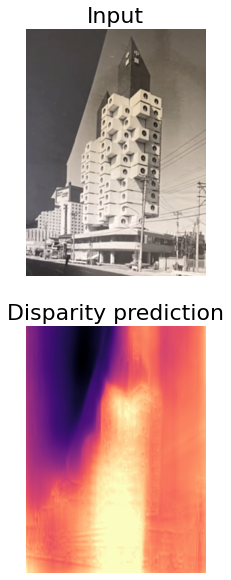

In [5]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)
print (vmax)
print (disp_resized_np)
len1 = len(disp_resized_np)
len2 = len(disp_resized_np[0])
print (len1)
print (len2)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)

r, g, b = input_image.getpixel((1, 1))
print(r, g, b)

plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [10]:
im = Image.new("RGBA", (482, 662))
draw = ImageDraw.Draw(im)  
text = ' ' 
  
# font = ImageFont.truetype(r'C:\Users\feliciachang\Desktop\16020_FUTURAM.ttf', 20)
text_path = "assets/Montserrat-Regular.ttf"

font = ImageFont.truetype(text_path, 100)
draw.text((0, 1), text, fill=(0, 0, 0, 244), font = font, align ="left")

im.show()

for i in range(len(disp_resized_np)):
    for j in range(len(disp_resized_np[i])):
#         print (i*len(disp_resized_np[i]) + j)
        flipy = len(disp_resized_np) - 1 - j;
        a, b, c, d = im.getpixel((i, flipy))

IndexError: image index out of range

In [11]:
thefile = open('test.obj', 'w')

print ("starting")

vectors = []

for i in range(len(disp_resized_np)):
    for j in range(len(disp_resized_np[i])):
        flipy = len(disp_resized_np) - 1 - j;
        r, g, b = input_image.getpixel((i, flipy))
        a, b, c, d = im.getpixel((i, flipy))
        if(a == 0 and b == 0 and c == 0 and d == 244):
            thefile.write("v {0} {1} {2} 0.0 0.0 0.0 0.5\n".format(i, j, 385*disp_resized_np[i][flipy]))
            vectors.append([i, j, disp_resized_np[i][j]])
        else:
            r, g, b = input_image.getpixel((i, flipy))
            thefile.write("v {0} {1} {2} {3} {4} {5} 1.0\n".format(i, j, 385*disp_resized_np[i][flipy], round(r/255, 4), round(g/255, 4), round(b/255, 4)))
            vectors.append([i, j, disp_resized_np[i][j]])

        
# for i in range(len(disp_resized_np)):
#     for j in range(len(disp_resized_np[i])):
#         flipy = len(disp_resized_np) - 1 - j;
#         a, b, c, d = im.getpixel((i, flipy))

        
print ("part 1")
print (len(vectors))
        
for i in range(len(disp_resized_np)):
    for j in range(len(disp_resized_np[i])):
        idx = i*len(disp_resized_np[i]) + j
        
        if(idx+len(disp_resized_np)+1 < len(vectors)):
            a = vectors[idx]
            b = vectors[idx+len(disp_resized_np)]
            c = vectors[idx+len(disp_resized_np)+1]
            diff1 = [b[0] - a[0], b[1] - a[1], b[2] - a[2]];
            diff2 = [c[0] - a[0], c[1] - a[1], c[2] - a[2]];
            cross = np.cross(diff1, diff2)
            #triangle2
            a2 = vectors[idx]
            b2 = vectors[idx+len(disp_resized_np)+1]
            c2 = vectors[idx+1]
            diff3 = [b2[0] - a2[0], b2[1] - a2[1], b2[2] - a2[2]];
            diff4 = [c2[0] - a2[0], c2[1] - a2[1], c[2] - a2[2]];
            cross2 = np.cross(diff3, diff4)
            thefile.write("vn {0} {1} {2}\n".format(round(cross[0], 4), round(cross[1], 4), round(cross[2], 4)))
            thefile.write("vn {0} {1} {2}\n".format(round(cross2[0], 4), round(cross2[1], 4), round(cross2[2], 4)))

    
thefile.write("usemtl Material\n")
thefile.write("s off\n")

print ("part 2")
        

normal = 1

for i in range(len(disp_resized_np)):
    for j in range(len(disp_resized_np[i])):
        idx = i*len(disp_resized_np[i]) + j
        if(idx+len(disp_resized_np)+1 < 148225):
            thefile.write("f {0}//{3} {1}//{3} {2}//{3}\n".format(idx+1, idx+len(disp_resized_np)+1, idx+len(disp_resized_np)+2, normal))
            thefile.write("f {0}//{3} {1}//{3} {2}//{3}\n".format(idx+1, idx+len(disp_resized_np)+2, idx+2, normal))
            normal+=1

print ("done")

thefile.close()

starting


IndexError: index 661 is out of bounds for axis 0 with size 482